# Epidemiology

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [3]:
# import functions from modsim

from modsim import *

In this chapter, we'll develop a model of an epidemic as it spreads in a
susceptible population, and use it to evaluate the effectiveness of
possible interventions.

My presentation of the model in the next few chapters is based on an excellent article by David Smith and Lang Moore, "The SIR Model for Spread of Disease," *Journal of Online Mathematics and its Applications*, December 2001, available at <http://modsimpy.com/sir>.

## The Freshman Plague

Every year at Olin College, about 90 new students come to campus from
around the country and the world. Most of them arrive healthy and happy, but usually at least one brings with them some kind of infectious disease. A few weeks later, predictably, some fraction of the incoming class comes down with what we call the "Freshman Plague".

In this chapter we introduce a well-known model of infectious disease,
the Kermack-McKendrick model, and use it to explain the progression of
the disease over the course of the semester, predict the effect of
possible interventions (like immunization) and design the most effective intervention campaign.

So far we have done our own modeling; that is, we've chosen physical
systems, identified factors that seem important, and made decisions
about how to represent them. In this chapter we start with an existing
model and reverse-engineer it. Along the way, we consider the modeling
decisions that went into it and identify its capabilities and
limitations.

## The Kermack-McKendrick Model

The Kermack-McKendrick (KM) model is an example of an *SIR model*,
so-named because it represents three categories of people:

-   *S*: People who are "susceptible", that is, capable of
    contracting the disease if they come into contact with someone who
    is infected.

-   *I*: People who are "infectious", that is, capable of passing
    along the disease if they come into contact with someone
    susceptible.

-   *R*: People who are "recovered". In the basic version of the
    model, people who have recovered are considered to be no longer
    infectious and immune to reinfection. That is a reasonable model for some diseases, but not for others, so it should be on the list of assumptions to reconsider later.

Let's think about how the number of people in each category changes over time. Suppose we know that people with the disease are infectious for a period of 4 days, on average.
If 100 people are infectious at a particular point in time, and we ignore the particular time each one became infected, we expect about 1 out of 4 to recover on any particular day.

Putting that a different way, if the time between recoveries is 4 days, the recovery rate is about 0.25 recoveries per day, which we'll denote with the Greek letter gamma, $\gamma$, or the variable name `gamma`.

If the total number of people in the population is $N$, and the fraction currently infectious is $i$, the total number of recoveries we expect per day is $\gamma i N$.

Now let's think about the number of new infections. Suppose we know that each susceptible person comes into contact with 1 person every 3 days, on average, in a way that would cause them to become infected if the other person is infected. We'll denote this contact rate with the Greek letter beta, $\beta$, or the variables name `beta`.

It's probably not reasonable to assume that we know $\beta$ ahead of
time, but later we'll see how to estimate it based on data from previous outbreaks.

If $s$ is the fraction of the population that's susceptible, $s N$ is
the number of susceptible people, $\beta s N$ is the number of contacts per day, and $\beta s i N$ is the number of those contacts where the other person is infectious.

In summary:

-   The number of recoveries we expect per day is $\gamma i N$; dividing by $N$ yields the fraction of the population that recovers in a day, which is $\gamma i$.

-   The number of new infections we expect per day is $\beta s i N$;
    dividing by $N$ yields the fraction of the population that gets
    infected in a day, which is $\beta s i$.

The KM model assumes that the population is closed; that is, no one
arrives or departs, so the size of the population, $N$, is constant.

## The KM Equations

If we treat time as a continuous quantity, we can write differential
equations that describe the rates of change for $s$, $i$, and $r$ (where $r$ is the fraction of the population that has recovered):

$$\begin{aligned}
\frac{ds}{dt} &= -\beta s i \\
\frac{di}{dt} &= \beta s i - \gamma i\\
\frac{dr}{dt} &= \gamma i\end{aligned}$$ 

To avoid cluttering the equations, I leave it implied that $s$ is a function of time, $s(t)$, and likewise for $i$ and $r$.

SIR models are examples of *compartment models*, so-called because
they divide the world into discrete categories, or compartments, and
describe transitions from one compartment to another. Compartments are
also called *stocks* and transitions between them are called
*flows*.

In this example, there are three stocks---susceptible, infectious, and
recovered---and two flows---new infections and recoveries. Compartment
models are often represented visually using stock and flow diagrams (see <http://modsimpy.com/stock>).

The following figure shows the stock and flow diagram for the KM model.

![Stock and flow diagram for an SIR
model.](https://github.com/AllenDowney/ModSim/raw/main/figs/stock_flow1.png)

Stocks are represented by rectangles, flows by arrows. The widget in the middle of the arrows represents a valve that controls the rate of flow; the diagram shows the parameters that control the valves.

## Implementing the KM model

For a given physical system, there are many possible models, and for a
given model, there are many ways to represent it. For example, we can
represent an SIR model as a stock-and-flow diagram, as a set of
differential equations, or as a Python program. The process of
representing a model in these forms is called *implementation*. In
this section, we implement the KM model in Python.

I'll represent the initial state of the system using a `State` object
with state variables `s`, `i`, and `r`; they represent the fraction of
the population in each compartment.

We can initialize the `State` object with the *number* of people in each compartment; for example, here is the initial state with one infected student in a class of 90:

In [4]:
init = State(s=89, i=1, r=0)
show(init)

,state
s,89
i,1
r,0


We can convert the numbers to fractions by dividing by the total:

In [5]:
init /= init.sum()
show(init)

,state
s,0.988889
i,0.011111
r,0.000000


For now, let's assume we know the time between contacts and time between
recoveries:

In [6]:
tc = 3             # time between contacts in days 
tr = 4             # recovery time in days

We can use them to compute the parameters of the model:

In [7]:
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

I'll use a `System` object to store the parameters and initial
conditions. The following function takes the system parameters and returns a new `System` object:

In [8]:
def make_system(beta, gamma):
    init = State(s=89, i=1, r=0)
    init /= init.sum()

    return System(init=init, t_end=7*14,
                  beta=beta, gamma=gamma)

The default value for `t_end` is 14 weeks, about the length of a
semester.

Here's what the `System` object looks like. 

In [9]:
system = make_system(beta, gamma)
show(system)

,value
init,s 0.988889 i 0.011111 r 0.000000 Name...
t_end,98
beta,0.333333
gamma,0.25


In [13]:
system.init

s    0.988889
i    0.011111
r    0.000000
Name: state, dtype: float64

Now that we have object to represent the system and its state, we are ready for the update function.

## The Update Function

The purpose of an update function is to take the current state of a system and compute the state during the next time step.
Here's the update function we'll use for the KM model:

In [14]:
def update_func(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(s=s, i=i, r=r)

`update_func` takes as parameters the current time, a `State` object, and a `System` object.

The first line unpacks the `State` object, assigning the values of the state variables to new variables with the same names.
This is an example of *multiple assignment*.
The left side is a sequence of variables; the right side is a sequence of expressions.
The values on the right side are assigned to the variables on the left side, in order.
By creating these variables, we avoid repeating `state` several times, which makes the code easier to read.

The update function computes `infected` and `recovered` as a fraction of the population, then updates `s`, `i` and `r`. The return value is a `State` that contains the updated values.

We can call `update_func` like this:

In [15]:
state = update_func(0, init, system)
show(state)

,state
s,0.985226
i,0.011996
r,0.002778


The result is the new `State` object.

You might notice that this version of `update_func` does not use one of its parameters, `t`. I include it anyway because update functions
sometimes depend on time, and it is convenient if they all take the same parameters, whether they need them or not.

## Running the Simulation

Now we can simulate the model over a sequence of time steps:

In [16]:
def run_simulation1(system, update_func):
    state = system.init

    for t in range(0, system.t_end):
        state = update_func(t, state, system)

    return state

The parameters of `run_simulation` are the `System` object and the
update function. The `System` object contains the parameters, initial
conditions, and values of `0` and `t_end`.

We can call `run_simulation` like this:

In [17]:
final_state = run_simulation1(system, update_func)
show(final_state)

,state
s,0.520568
i,0.000666
r,0.478766


The result indicates that after 14 weeks (98 days), about 52% of the
population is still susceptible, which means they were never infected,
almost 48% have recovered, which means they were infected at some point, and less than 1% are actively infected.

## Collecting the Results

The previous version of `run_simulation` returns only the final state,
but we might want to see how the state changes over time. We'll consider two ways to do that: first, using three `TimeSeries` objects, then using a new object called a `TimeFrame`.

Here's the first version:

In [18]:
def run_simulation2(system, update_func):
    S = TimeSeries()
    I = TimeSeries()
    R = TimeSeries()

    state = system.init
    S[0], I[0], R[0] = state
    
    for t in range(0, system.t_end):
        state = update_func(t, state, system)
        S[t+1], I[t+1], R[t+1] = state.s, state.i, state.r
    
    return S, I, R

First, we create `TimeSeries` objects to store the results.
Next we initialize `state` and the first elements of `S`, `I` and
`R`.

Inside the loop, we use `update_func` to compute the state of the system at the next time step, then use multiple assignment to unpack the elements of `state`, assigning each to the corresponding `TimeSeries`.

At the end of the function, we return the values `S`, `I`, and `R`. This is the first example we have seen where a function returns more than one value.

We can run the function like this:

In [19]:
S, I, R = run_simulation2(system, update_func)

We'll use the following function to plot the results:

In [20]:
def plot_results(S, I, R):
    S.plot(style='--', label='Susceptible')
    I.plot(style='-', label='Infected')
    R.plot(style=':', label='Recovered')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

And run it like this:

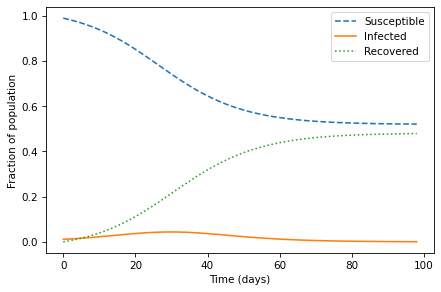

In [21]:
plot_results(S, I, R)

It takes about three weeks (21 days) for the outbreak to get going, and about five weeks (35 days) to peak. The fraction of the population that's infected is never very high, but it adds up. In total, almost half the population gets sick.

## Now With a TimeFrame

If the number of state variables is small, storing them as separate
`TimeSeries` objects might not be so bad. But a better alternative is to use a `TimeFrame`, which is another object defined in the ModSim
library.
A `TimeFrame` is a kind of a `DataFrame`, which we used earlier to store world population estimates.

Here's a more concise version of `run_simulation` using a `TimeFrame`:

In [22]:
def run_simulation(system, update_func):
    frame = TimeFrame(columns=system.init.index)
    frame.loc[0] = system.init
    
    for t in range(0, system.t_end):
        frame.loc[t+1] = update_func(t, frame.loc[t], system)
    
    return frame

The first line creates an empty `TimeFrame` with one column for each
state variable. Then, before the loop starts, we store the initial
conditions in the `TimeFrame` at `0`. Based on the way we've been using
`TimeSeries` objects, it is tempting to write:

```
frame[0] = system.init
```

But when you use the bracket operator with a `TimeFrame` or `DataFrame`, it selects a column, not a row. 
To select a row, we have to use `loc`, like this:

```
frame.loc[0] = system.init
```

Since the value on the right side is a `State`, the assignment matches
up the index of the `State` with the columns of the `TimeFrame`; that
is, it assigns the `s` value from `system.init` to the `s` column of
`frame`, and likewise with `i` and `r`.

Each time through the loop, we assign the `State` we get from `update_func` to the next row of `frame`.
At the end, we return `frame`. 

We can call this version of `run_simulation` like this:

In [23]:
results = run_simulation(system, update_func)

Here are the first few rows of the results.

In [24]:
results.head()

,s,i,r
0,0.988889,0.011111,0.000000
1,0.985226,0.011996,0.002778
2,0.981287,0.012936,0.005777
3,0.977055,0.013934,0.009011
4,0.972517,0.014988,0.012494


The columns in the `TimeFrame` correspond to the state variables, `s`, `i`, and `r`.
As with a `DataFrame`, we can use the dot operator to select columns
from a `TimeFrame`, so we can plot the results like this:

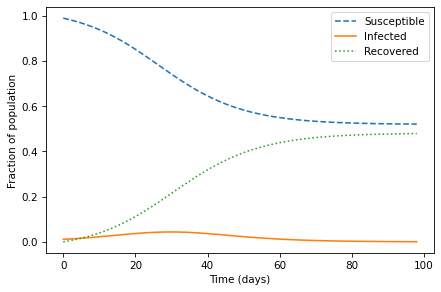

In [25]:
plot_results(results.s, results.i, results.r)

The results are the same as before, now in a more convenient form.

## Summary

This chapter presents an SIR model of infectious disease and two ways to collect the results, using several `TimeSeries` objects or a single `TimeFrame`.
In the next chapter we'll use the model to explore the effect of immunization.

But first you might want to work on these exercises.

## Exercises

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
You can access the notebooks at <https://allendowney.github.io/ModSimPy/>.

### Exercise 1  

Suppose the time between contacts is 4 days and the recovery time is 5 days.  After 14 weeks, how many students, total, have been infected?

Hint: what is the change in `S` between the beginning and the end of the simulation?

In [26]:
tc = 4             # time between contacts in days 
tr = 5             # recovery time in days

In [27]:
beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

In [28]:
system = make_system(beta, gamma)
show(system)

,value
init,s 0.988889 i 0.011111 r 0.000000 Name...
t_end,98
beta,0.25
gamma,0.2


In [31]:
system.t_end = 14

In [32]:
S, I, R = run_simulation2(system, update_func)

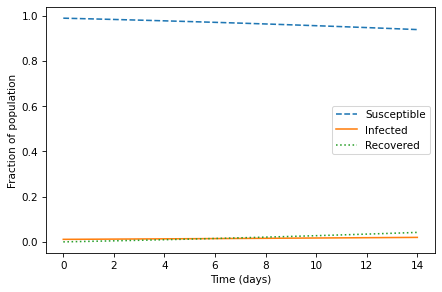

In [33]:
plot_results(S, I, R)

In [34]:
S

Time
0     0.988889
1     0.986142
2     0.983273
3     0.980280
4     0.977159
5     0.973908
6     0.970524
7     0.967005
8     0.963349
9     0.959555
10    0.955622
11    0.951549
12    0.947335
13    0.942981
14    0.938488
Name: Quantity, dtype: float64

In [43]:
Fraction_Start = 89/90
S_Start = Fraction_Start * 90

In [48]:
Fraction_End = S.iloc[-1]
S_End = Fraction_End *90

In [56]:
print("We started with {:.0f} healthy students".format(S_Start))
print("We ended with {:.0f} healthy students".format(S_End))
print("After 14 weeks, {:.0f} student got infected".format(S_Start - S_End))



We started with 89 healthy students
We ended with 84 healthy students
After 14 weeks, 5 student got infected
